**Individual Graded Exercise 2**

**Part 1: Analyze the Fake News Dataset**

In [1]:
import re
import pandas as pd
!pip install clean-text
from cleantext import clean
from collections import Counter
import matplotlib.pyplot as plt
import requests
from bs4 import BeautifulSoup

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 175.4/175.4 kB 3.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.4/53.4 kB 4.6 MB/s eta 0:00:00
  Created wheel for emoji: filename=emoji-1.7.0-py3-none-any.whl size=171033 sha256=584f7177f9b64e336f3db6d127badf7969cb5286292dda46040db24fafa5fd66
  Stored in directory: /root/.cache/pip/wheels/31/8a/8c/315c9e5d7773f74b33d5ed33f075b49c6eaeb7cedbb86e2cf8
Successfully built emoji


**1. Import Dataset**
Going to run the cleaning step here instead.

In [2]:
raw_data = pd.read_csv("https://raw.githubusercontent.com/several27/FakeNewsCorpus/master/news_sample.csv", index_col = 0)
clean_data = raw_data.copy()

In [3]:
clean_anon = (lambda x: clean(x,
        fix_unicode=False,               # fix various unicode errors
        to_ascii=False,                  # transliterate to closest ASCII representation
        lower=True,                     # lowercase text
        no_line_breaks=False,           # fully strip line breaks as opposed to only normalizing them
        no_urls=True,                  # replace all URLs with a special token
        no_emails=True,                # replace all email addresses with a special token
        no_phone_numbers=False,         # replace all phone numbers with a special token
        no_numbers=True,               # replace all numbers with a special token
        no_digits=True,                # replace all digits with a special token
        no_currency_symbols=False,      # replace all currency symbols with a special token
        no_punct=False,                 # remove punctuations
        replace_with_punct="",          # instead of removing punctuations you may replace them
        replace_with_url="<URL>",
        replace_with_email="<EMAIL>",
        replace_with_phone_number="<PHONE>",
        replace_with_number="<NUM>",
        replace_with_digit="0",
        replace_with_currency_symbol="<CUR>",
        lang="en"                       # set to 'de' for German special handling
    )
)

In [4]:
clean_data['content'] = raw_data['content'].apply(clean_anon)

In [5]:
results = clean_data.loc[:,('content')].str.split().sum()
unique_word_count = len(set(results))
print('Unique words after simple cleaning: {}'.format(unique_word_count))

Unique words after simple cleaning: 25640


**2. Dataset Analysis**

**Pre omition analysis**



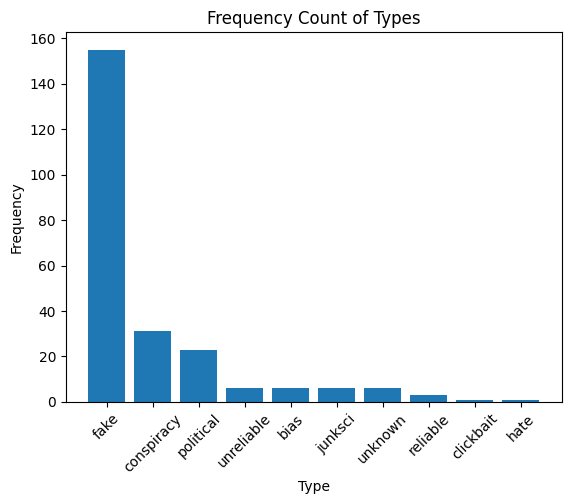

fake          155
conspiracy     31
political      23
unreliable      6
bias            6
junksci         6
unknown         6
reliable        3
clickbait       1
hate            1
Name: type, dtype: int64

beforeitsnews.com            155
canadafreepress.com           24
washingtonexaminer.com        17
www.newsmax.com                7
awarenessact.com               6
naturalnews.com                5
strategic-culture.org          4
willyloman.wordpress.com       4
christianpost.com              3
city-journal.org               2
vdare.com                      2
undergroundhealth.com          2
awm.com                        2
alternet.org                   2
collectivelyconscious.net      1
breakpoint.org                 1
unz.com                        1
21stcenturywire.com            1
washingtonsblog.com            1
barenakedislam.com             1
charismanews.com               1
blackagendareport.com          1
americanlookout.com            1
anonhq.com                     1
bi

In [6]:
#clean_data['content'].describe()
duplicates = clean_data[clean_data.duplicated('content', keep=False)]
type_counts = clean_data['type'].value_counts()
domain_counts = clean_data['domain'].value_counts()

plt.bar(type_counts.index, type_counts.values)
plt.xlabel('Type')  # Optional: Label for the x-axis
plt.ylabel('Frequency')  # Optional: Label for the y-axis
plt.title('Frequency Count of Types')  # Optional: Title of the plot
plt.xticks(rotation=45)  # Optional: Rotate x-axis labels to avoid overlap
plt.show()

print(type_counts)
print("")
print(domain_counts)

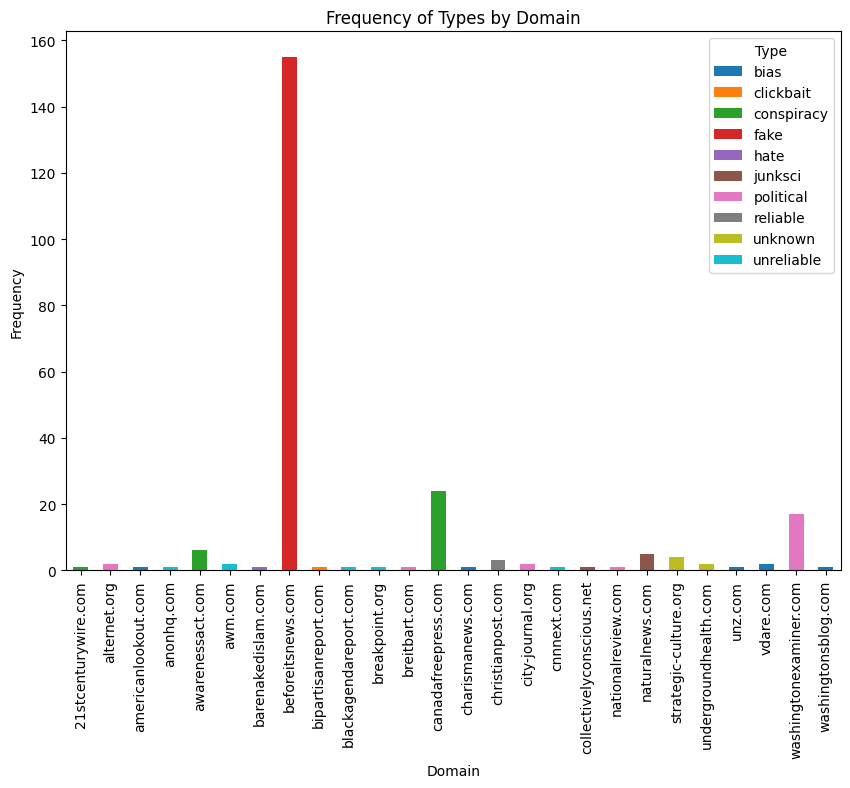

In [7]:
frequency_by_domain = clean_data.groupby(['domain', 'type']).size().reset_index(name='Frequency')
pivot_table = frequency_by_domain.pivot(index='domain', columns='type', values='Frequency').fillna(0)

pivot_table.plot(kind='bar', stacked=True, figsize=(10, 7))
plt.xlabel('Domain')
plt.ylabel('Frequency')
plt.title('Frequency of Types by Domain')
plt.xticks(rotation=90)
plt.legend(title='Type')
plt.show()

**A. Which article types should be omitted if any?**

Assuming that the task will be differentiating between real and fake news then the following types will be omitted:

*   **unknown** - the frequency is low enough to not do any value insertion
*   **bias** - the description says that it may rely on decontextualized data which
could be grouped under fake news but chosen to be omitted because of the low frequency although further analysis might prove otherwise.
*   **junksci** - again ambigious and may promote fake information and since the frequency is low the cost of further analysis seems not worth it initially.
*   **hate** - as much as I want to straight up classify this as fake it is ambigious and might report real or fake news to support the hate or angled. Low frequncy and not worth further analysis initially.
*   **clickbait** - if it generally provides credible content it is still ambigious and low frequency makes it not worth considering initially.
*   **unrealiable** - ambigious data and credibility is unclassified. Low frequency. If more data on fake or reliable news are needed these could be further analysed for credibility.
*   **political** - The benefits of omitting this type of articles are that they generally provide verifiable information but it is in support of certain points of view which may or may not present it in a credible way. There is also a bit of amibiguity on this type. It does constitute a big part of the dataset. I would have asked for help from domain experts on their thoughts on this category because of lack of knowledge.

**B**

The Following will be grouped as fake:

*   **conspiracy** - a subset of fake news promoting kooky conspiracy theories.
*   **fake** - the definition of fake news.

The only types under reliable articles will be the type "reliable", the fake articles types, "conspiracy, fake" and the reasoning for omitting the other types are given in **A**.

**C**

The dataset is not balanced. It is important to have a somewhat balanced dataset since only learning how a fake news article looks won't necesarilly tell us the opposite although I can imagine methods existing for a making this work anyway. Information on all types allows us to generally better distinguish between the different types. If we are using this dataset to train a model it will also be difficult to split the dataset up and evalute since the majority is fake.

In [8]:
# Function to map types to new groups
def map_to_group(type_value):
    if type_value in ['fake', 'conspiracy']:
        return 'GroupFake'
    elif type_value == 'reliable':
        return 'GroupReliable'
    else:
        return 'GroupOmitted'

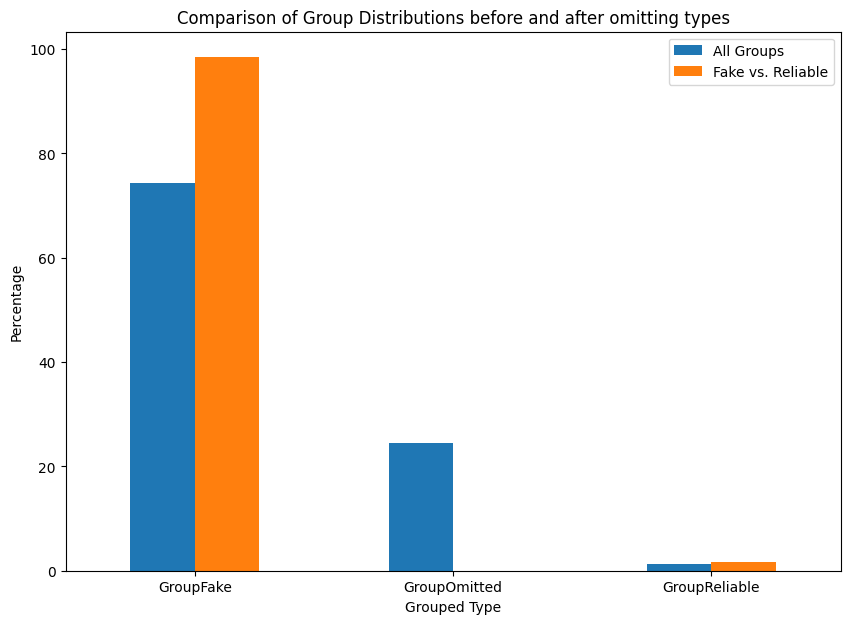

In [9]:
# Apply the function to create a new 'GroupedType' column
clean_data['GroupedType'] = clean_data['type'].apply(map_to_group)

# All groups percentage
all_groups_counts = clean_data['GroupedType'].value_counts()
all_groups_percentage = all_groups_counts / all_groups_counts.sum() * 100

# 'GroupFake' and 'GroupReliable' only percentage
filtered_counts = clean_data[clean_data['GroupedType'].isin(['GroupFake', 'GroupReliable'])]['GroupedType'].value_counts()
filtered_percentage = filtered_counts / filtered_counts.sum() * 100

# Combine data into a single DataFrame for plotting
comparison_df = pd.DataFrame({'AllGroups': all_groups_percentage, 'FakeVsReliable': filtered_percentage}).fillna(0)

comparison_df.plot(kind='bar', figsize=(10, 7))
plt.xlabel('Grouped Type')
plt.ylabel('Percentage')
plt.title('Comparison of Group Distributions before and after omitting types')
plt.xticks(rotation=0)
plt.legend(['All Groups', 'Fake vs. Reliable'])
plt.show()

**Part 2: Gathering Links**

**2. Retrieve HTML content:**

Visually using developer tools on the page and inspecting the downloaded content looks the same.

**3. Extract articles:**

For this part the beautifulsoup find_all part did not work on google colab so I ran it locally and produced a txt containing the links with the following code:


```
import requests
from bs4 import BeautifulSoup

response = requests.get('https://www.bbc.com/news/world/europe')
contents = response.text

soup = BeautifulSoup(contents, 'html.parser')

def extract_article_links(soup_element):
    # Find all elements that are marked as articles
    articles = soup_element.find_all(attrs={'type': 'article'})
    
    # For each article, find the <a> tag and extract the 'href'
    links = [article.find('a').get('href') for article in articles if article.find('a')]
    
    return links

links = extract_article_links(soup)

# Write a function that extracts articles from all the pages
def extract_articles_from_all_pages(country, num_pages):
    # Create an empty list to store the links
    all_links = []
    
    # Loop through the pages
    for page in range(1, num_pages):
        # Construct the URL
        url = f'https://www.bbc.com/news/world/{country}?page={page}'
        
        # Make the request
        response = requests.get(url)
        
        # Extract the contents
        contents = response.text
        
        # Create a soup object
        soup = BeautifulSoup(contents, 'html.parser')
        
        # Extract the links
        links = extract_article_links(soup)
        
        # Add the links to the list
        all_links.extend(links)
    
    return all_links

all_links = []

regions_and_pages = [("africa", 25), ("asia",42), ("australia", 42), ("europe", 42), ("latin_america", 42), ("middle_east", 41)]
all_links.extend(extract_articles_from_all_pages("africa", 25))
for region, pages in regions_and_pages:
    all_links.extend(extract_articles_from_all_pages(region, pages))

# Open a file for writing (this will create the file if it doesn't exist)
with open('article_links.txt', 'w') as file:
    # Iterate over the list and write each element to the file
    for item in all_links:
        file.write(f"{item}\n")

```



***Part 3: Scraping Article Text***

Following code was used for this part due to colab issue with beutiful soup:


```
import requests
from bs4 import BeautifulSoup
import json
import time

def soupify_url(url):
    response = requests.get(url)
    contents = response.text
    return BeautifulSoup(contents, 'html.parser')

def extract_article_title(soup_element):
    # Find and store the headline, published date and author
    text = soup_element.find_all('p', class_="ssrcss-1q0x1qg-Paragraph e1jhz7w10")
    full_text = ' '.join(paragraph.text for paragraph in text)
    headline = soup_element.find(id='main-heading')
    published_date = soup_element.find(attrs={'data-testid': 'timestamp'})
    datetime_value = published_date['datetime'] if published_date else 'None'
    author = soup_element.find('div', class_="ssrcss-68pt20-Text-TextContributorName e8mq1e96")
    author_name = author.text if author else 'None'
    # Store the values in a dictionary
    article_dict = {}
    article_dict['text'] = full_text
    article_dict['headline'] = headline.text if headline else 'None'
    article_dict['published_date'] = datetime_value
    article_dict['author'] = author_name
    
    # For each article, find the <a> tag and extract the 'href'
    # links = [article.find('a').get('href') for article in articles if article.find('a')]
    
    return article_dict

base_url = "https://www.bbc.com"


# Open the text file for reading ('r' mode)
with open('article_links.txt', 'r') as file, open('article_info.json', 'w') as jsonfile:
    # Loop through each line in the file
    for line in file:
        # Concatenate each line to the base_url
        url = base_url + line.strip()
        
        # Call the soupify_url function to get the BeautifulSoup object
        soup = soupify_url(url)
        
        # Call the extract_article_title function to extract the article information
        article_info = extract_article_title(soup)
        
        # Write the article information to the CSV file
        json.dump(article_info, jsonfile)

        # add a delay to avoid being blocked
        time.sleep(1)
```

*** 5. Discussion ***

Different datasets and these are all from one source. How do we classify them compared to the others?

These should definitely not be added to the dataset unless there is an existing guideline on how to ensure data quality.